### About 

This notebooks trains an image segementation network with modified MobileNetV3 + UNet structure on the full MaSTr1325 dataset. The results are preliminarily evaluated based on a shoreline per-pixel accuracy, and subsequently exported and evaluated separately in MATLAB. 

```
Dataset   : 'mastr.zip' 
                1325 images 

Labels
  Obstacles and environment = 0
  Water = 1
  Sky = 2
  Ignore region / unknown category = 4

X: ? x 384 x 512 x 3 .png files
y: ? x 384 x 512     .png files 
```

Note that this script was originally ran in google colab and processed dataset is loaded from the drive. You can recreate the workflow by following documentations below

Find evaluation code here:  https://github.com/bborja/modd

Find dataset here: https://box.vicos.si/borja/viamaro/index.html

We kindly ask you to cite our papers if you use the provided code below.

```
@inproceedings{yao2021shorelinenet,
  title={ShorelineNet: An Efficient Deep Learning Approach for Shoreline Semantic Segmentation for Unmanned Surface Vehicles},
  author={Yao, Linghong and Kanoulas, Dimitrios and Ji, Ze and Liu, Yuanchang},
  booktitle={Proceedings of the... IEEE/RSJ International Conference on Intelligent Robots and Systems. IEEE/RSJ International Conference on Intelligent Robots and Systems},
  year={2021},
  organization={IEEE}
}
```




In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Set path for drive with datasets
drive_path ="/content/drive/MyDrive/3rd_year_project_UCL/dataset"

Mounted at /content/drive


### Imports & Installs 


In [2]:
import sys
# Install tfds-nightly for upsampling layer
!{sys.executable} -m pip install -q git+https://github.com/tensorflow/examples.git
!{sys.executable} -m pip install -q -U tfds-nightly
# Install tfa for transformations
!{sys.executable} -m pip install -q -U tensorflow-addons
#  Install other modules
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install Pillow
!{sys.executable} -m pip install wget
# Install tfds-nightly for upsampling layer
# !pip install -q git+https://github.com/tensorflow/examples.git
# !pip install -q -U tfds-nightly
# Install tfa for transformations
# !pip install -q -U tensorflow-addons


  Preparing metadata (setup.py) ... done
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/

In [3]:
import os
import re
import random
import time
import math
import datetime

import tensorflow as tf
import tensorflow_addons as tfa

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import wget

from PIL import Image as pimage 
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

from tqdm.notebook import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load data from google drive

**MasTr Dataset**

In [ ]:
# Select path to MasTr dataset WIP
# MasTrPath = 'https://box.vicos.si/borja/mastr1325_dataset/MaSTr1325_images_512x384.zip'
# filename = wget.download(MasTrPath)


In [4]:
# Download data from Google colab
if 'data' not in os.listdir():
   !cp {drive_path+"/mastr.zip"} .
   !unzip -q 'mastr.zip' -d data
   !rm 'mastr.zip'

```
data
  - masks
  - images

Image names: 
  0001.jpg
  384 x 512 x 3
Annotation image names: 
  0001m.png
  384 x 512 x 1 (0: obstacle, 1: water, 2: sky)
```



**MODD2 Dataset**

In [5]:
# Footage 1 to 28, used to export prediction & evaluate in MATLAB
# Download data from colab
if 'eval_data' not in os.listdir():
  !cp {drive_path+"/eval_data_highres.zip"} .
  !unzip -q 'eval_data_highres.zip' -d eval_data
  !rm 'eval_data_highres.zip'


```
eval_data
  - images
  - masks
 
Image names: 
  27_001.jpg 
  128 x 128 x 3
Annotation image names: 
  27_001m.png
  128 x 128 x 1 (background-pixel = 0, sea-pixel = 1)
```



### Dataset Pipeline - functions

1. `list_files`: get file names from directory 
2. `parse_image` : loads image & its corresponding label 
3. `load_image_train` and `load_image_test`: augmentation & normalize
4. `configure_ds`: cache, batch, and prefetch



In [6]:
def parse_image(img_path: str) -> dict:
    '''
    Loads the image and its mask, returns a dictionary

    Original      Returns
    0: obstacle   0: obstacle
    1: water      1: water
    2: sky        2: sky
    4: unknown    3: unknown

    Args
    ----------
    img_path : str
        Image filename pattern (glob)
        (Mask location is found using regex)

    Returns
    ----------
    dict {'image': tensor (384 x 512 x 3), 'mask': tensor (384 x 512 x 3)}
        Dictionary mapping an image and its annotation.
    '''
    # Read image
    image = tf.io.read_file(img_path)
    # Decode image into 3 channels for each pixel in uint8 format (RGB colours)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert image to uint8
    image = tf.image.convert_image_dtype(image, tf.dtypes.uint8)

    # For one Image path:
    # .../data/images/train/01_001.png
    # Its corresponding annotation path is:
    # .../data/annotations/train/01_001_label.png

    # Create mask path from image path as per default folder structure from download zip
    # .../ShorelineNet/MasTr1325_images_512x384
    # Becomes
    # .../ShorelineNet/MasTr1325_masks_512x384
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask_path = tf.strings.regex_replace(mask_path, ".jpg", "m.png")

    # Read mask path
    mask = tf.io.read_file(mask_path)
    # Decode mask to 1 channel in uint8
    mask = tf.image.decode_png(mask, channels=1, dtype=tf.dtypes.uint8) #+ 1
    # Redefine type 4 to 3 - unknown
    mask = tf.where(mask == 4, np.dtype('uint8').type(3), mask)
    # mask = tf.where(mask == 5, float(nan), mask )

    return {'image': image, 'mask': mask}

In [7]:
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    '''
    Rescale the pixel values of the images from [0, 255] to [0, 1]

    Args
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [384,512,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an annotation of size [384,512,1].

    Returns
    ----------
    tuple
        Normalized image and its annotation.
    '''

    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)
    return input_image, input_mask


In [8]:
def load_image_train(datapoint: dict) -> tuple:
    '''
    Apply some transformations to an input dictionary
    containing an image and its annotation.

    Note: should be applying to training set only

    Args
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    ----------
    tuple
        A modified image and its annotation.
    '''
    # set input image and mask to data from disctionary input
    input_image = datapoint['image']
    input_mask = datapoint['mask']
    height, width = 384, 512

    # Flip half
    if tf.random.uniform(()) > 0.5:
      input_image = tf.image.flip_left_right(input_image)
      input_mask = tf.image.flip_left_right(input_mask)
    
    # Randomise hue, saturation, contrast and brightness
    if tf.random.uniform(()) > 0.2:
      input_image = tf.image.random_hue(input_image, 0.2)
      input_image = tf.image.random_saturation(input_image, 0.8, 1.2)
      input_image = tf.image.random_contrast(input_image, 0.6, 1.4)
      input_image = tf.image.random_brightness(input_image, 0.2)

    # Rotation up to 22.5 deg either way
    if tf.random.uniform(()) > 0.2:
      alpha = tf.random.uniform((), -math.pi/8, math.pi/8) # random between -pi/8 and pi/8
      input_image = tfa.image.rotate(tf.cast(input_image, dtype=tf.int32), alpha) # cast to int32 and rotate by the random angle
      input_mask = tfa.image.rotate(tf.cast(input_mask, dtype=tf.int32), alpha, fill_value=3) # fills unknown data outside the boundaries after rotation
      # Recast to unit8
      input_image = tf.cast(input_image, dtype=tf.uint8)
      input_mask = tf.cast(input_mask, dtype=tf.uint8)

    # Scaling randomly between 70% and 90% of original size and fit at random location within bounding box
    if tf.random.uniform(()) > 0.2:
      crop_width = tf.random.uniform(shape=(), minval=math.floor(0.7 * width), maxval=math.floor(0.9 * width), dtype = tf.int32)
      crop_height = tf.random.uniform(shape=(), minval=math.floor(0.7 * height), maxval=math.floor(0.9 * height), dtype = tf.int32)

      offset_x = tf.random.uniform(shape=(), minval=0, maxval=(width - crop_width), dtype = tf.int32)
      offset_y = tf.random.uniform(shape=(), minval=0, maxval=(height - crop_height), dtype = tf.int32)

      input_image = tf.image.crop_to_bounding_box(input_image, offset_y, offset_x, crop_height, crop_width)
      input_mask = tf.image.crop_to_bounding_box(input_mask, offset_y, offset_x, crop_height, crop_width)

    # Resize image to given image size
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')

    # Normalize & clip
    input_image, input_mask = normalize(input_image, input_mask) # Normalize by casting to float (and scaling by uint8 for image)
    input_image = tf.clip_by_value(input_image, clip_value_min=0., clip_value_max=1.) #Clip to maximum 1 and minimum 0

    return input_image, input_mask

In [9]:
def load_image_test(datapoint: dict) -> tuple:
    '''
    Normalize and resize a test image and its annotation, no augmentation

    Note: 
      Applies to both validation and testing set

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its annotation.

    Returns
    -------
    tuple
        A modified image and its annotation.
    '''

    # input_image = datapoint['image']
    # input_mask = datapoint['mask']

    # Resize
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['mask'], (IMG_SIZE, IMG_SIZE))

    # Normalize
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

### Dataset Pipeline - execute

In [10]:

# Set square image size
IMG_SIZE = 224
# Batch size is set to 32 in order to see if inference at real time is possible
BATCH_SIZE = 64
N_CLASSES = 3         # 0: obstacle, 1: water, 2: sky
TRAIN_VAL_RATIO = 0.90 # Within the MasTr dataset


# For reproducible result 
SEED = 321
# tf.random.set_seed(SEED)

In [22]:
# Set paths to file directories
data_dir = os.path.join(os.getcwd(), 'data/')
images_path = os.path.join(data_dir, 'images/')
labels_path = os.path.join(data_dir, 'masks/')

test_data_dir = os.path.join(os.getcwd(), 'test_data/')
test_images_path = os.path.join(test_data_dir, 'images/')
test_labels_path = os.path.join(test_data_dir, 'masks/')

eval_data_dir = os.path.join(os.getcwd(), 'eval_data/')
eval_images_path = os.path.join(eval_data_dir, 'images/')
eval_labels_path = os.path.join(eval_data_dir, 'masks/')

# images_path = os.path.join(os.getcwd(),'MasTr1325_images_512x384/')
# labels_path = os.path.join(os.getcwd(),'MasTr1325_masks_512x384/')

# test_images_path = os.path.join(os.getcwd(),'MasTr1325_images_512x384/')
# test_labels_path = os.path.join(os.getcwd(),'MasTr1325_masks_512x384/')

# eval_images_path = os.path.join(os.getcwd(),'MODD2_video_data/','video_data/')
# eval_labels_path = os.path.join(os.getcwd(),'annotations_v2_redone/')

# Count number of images and print
total_image_count = len(os.listdir(images_path))

print('total number of images:      {}'.format(total_image_count))

total number of images:      1325


In [27]:
# Get list of all image files in dataset list_dir - shuffle names randomly but use seed to get deterministic order
list_dir = tf.data.Dataset.list_files(images_path + '*.jpg', shuffle=True, seed=SEED)
# test_ds = tf.data.Dataset.list_files(test_images_path + '*.jpg', shuffle=False)

# Evaluation file dataset for all eval_images
test_sequence_folders = ['seq27', 'seq28']
eval_ds = tf.data.Dataset.list_files(eval_images_path + 'seq*' + '/*.jpg', shuffle=False)
test_ds = tf.data.Dataset.list_files([eval_images_path + seq + '/*.jpg' for seq in test_sequence_folders], shuffle=False)

# Test folders only sequence 27 and 28 - i.e. last two folders in import
# test_sequence_folders = ['kope82-00-00011177-00011797', 'kope82-00-00012030-00012700']
# Evaluation file dataset for all eval_images
# eval_ds = tf.data.Dataset.list_files(eval_images_path + 'kope*' + '/frames' + '/*.jpg', shuffle=False)
# Test dataset for each sequence folder (27 & 28)
# test_ds = tf.data.Dataset.list_files([eval_images_path + seq + '/frames' + '/*.jpg' for seq in test_sequence_folders], shuffle=False)

# # Get list of file names for train and val - TRAIN_VAL_RATIO decides how many of the images are used for training and how many are used for validation
train_length = round(total_image_count * TRAIN_VAL_RATIO)
train_ds = list_dir.take(train_length)
val_ds = list_dir.skip(train_length)

# Get length of each dataset
TRAINSET_SIZE = tf.data.experimental.cardinality(train_ds).numpy() # size of dataset used to train (MasTr)
VALSET_SIZE = tf.data.experimental.cardinality(val_ds).numpy() # Size of dataset used to validate (MasTr)
TEST_SIZE = tf.data.experimental.cardinality(test_ds).numpy() # Size of dataset used to test (MODD2)
EVAL_SIZE = tf.data.experimental.cardinality(eval_ds).numpy() # Siize of dataset used to evaluate (MODD2)

print(f'Train: {TRAINSET_SIZE}, Val: {VALSET_SIZE}, Test: {TEST_SIZE}, Eval: {EVAL_SIZE}')

Train: 1192, Val: 133, Test: 1292, Eval: 11703


In [28]:
# Run parse_image on all dataset entries
# Parses images to uint8 x3 RGB for images and x1 for masks of water, sky, obstacle and unknown

train_ds = train_ds.map(parse_image)
val_ds = val_ds.map(parse_image)
test_ds = test_ds.map(parse_image)
eval_ds = eval_ds.map(parse_image)



In [29]:
# Training set:
#           cache -> shuffle -> Augment -> batch -> repeat -> prefetch

# Validation set:
# Resize -> cache -> shuffle -> batch ->                      prefetch

# Test & Eval set:
# Resize -> batch

train_ds = train_ds.cache() # cache dataset for it to be used over iterations
train_ds = train_ds.shuffle(buffer_size=1000) # Shuffle to ensure dataset is not in the same order on every iteration
train_ds = train_ds.map(load_image_train, num_parallel_calls=AUTOTUNE) # applies load_image_train to all training images (preprocess)
train_ds = train_ds.batch(batch_size=BATCH_SIZE) # Batches training images into size 64 (as given above)
train_ds = train_ds.repeat() # Repeats dataset indefinitely to avoid errors
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE) # Allows prefetching of elements while later elements are prepared

val_ds = val_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run val image load
val_ds = val_ds.cache().batch(batch_size=BATCH_SIZE).prefetch(buffer_size=AUTOTUNE) # Cache

test_ds = test_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run test image load
test_ds = test_ds.cache().batch(batch_size = BATCH_SIZE) # Cache
# runtime_test_ds = test_ds.cache().batch(batch_size=TEST_SIZE)

eval_ds = eval_ds.map(load_image_test, num_parallel_calls=AUTOTUNE) # Run eval image load
eval_ds = eval_ds.batch(batch_size = BATCH_SIZE) # Batch

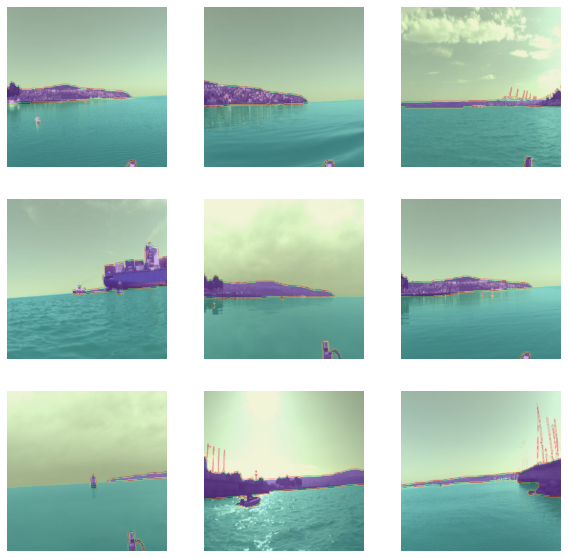

In [41]:
### Display images

# train_ds.skip(37)
for image_batch, mask_batch in val_ds.take(1): # Both a mask and an image batch stored in val_ds
  plt.figure(figsize=(10, 10)) # create 10 by 10 inch figure
  for i in range(9): # 0 through 8
    ax = plt.subplot(3, 3, i + 1) # Create subplot
    image = image_batch[i] 
    mask = mask_batch[i] # Take given image and mask
    plt.imshow(image) # Plot image
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask), alpha=0.3, cmap='rainbow') # Convert mask to PIL, make transparent with alpha and apply colourmap
    plt.axis("off")
  break
# i = 0
# display([image_batch[i], mask_batch[i]])

### Model Definition

In [42]:
tf.keras.backend.clear_session() # Clear the state and frees up memory

# Encoder
# base_model = tf.keras.applications.MobileNetV3Small(input_shape=[224, 224, 3], include_top=False, weights='imagenet')
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False) # Base model is on mobilenetV2 encoder

# Extract the activations of these layers (relu)
layer_names = [
    'block_1_expand_relu',   # 64 x 64 x 96
    'block_3_expand_relu',   # 32 x 32 x 144
    'block_6_expand_relu',   # 16 x 16 x 192
    'block_13_expand_relu',  # 8  x 8  x 576
    'block_16_project',      # 4  x 4  x 320
]

layers = [base_model.get_layer(name).output for name in layer_names] # get all layers by the names given in layer_names

# # Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers) # create model (encoder stack)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [43]:
def deconv_block(filters, size, norm_type='batchnorm', dropout_rate = 0.5):
  '''
  Conv2DTranspose => Batchnorm => Dropout => Relu
  '''
  initializer = tf.random_normal_initializer(0., 0.02) # Initialises value randomly from normal distribution
  # tf.keras.initializers.HeNormal(seed=None)
  result = tf.keras.Sequential() # groups layers to stack (creates stack here)
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                      use_bias=False)) # Adds deconvolutional layer
  result.add(tf.keras.layers.BatchNormalization()) # adds batch normalisation layer
  # result.add(tf.keras.layers.Dropout(dropout_rate))
  result.add(tf.keras.layers.ReLU()) # Add activation function
  return result # Spit out upsampling block

In [44]:
# Decoder
up_stack = [
    deconv_block(512, 3, dropout_rate = 0.5),  # 4x4 -> 8x8
    deconv_block(256, 3, dropout_rate = 0.4),  # 8x8 -> 16x16
    deconv_block(128, 3, dropout_rate = 0.3),  # 16x16 -> 32x32
    deconv_block(64, 3, dropout_rate = 0.2),   # 32x32 -> 64x64
] # Create decoder from 4 upsampling blocks of each the layers in devonv_block

In [46]:
def unet_model(output_channels):
  ''' Instantiate a new instance of UNet Model '''
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])
  x = inputs # Instantiate keras tensor

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1] # Last layer
  skips = reversed(skips[:-1]) # Run through from last to first

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Visualisation functions

In [47]:
def create_mask(pred_mask):
  ''' Finds top prediction mask and returns it'''
  pred_mask = tf.argmax(pred_mask, axis=-1) # Best fit mask
  pred_mask = pred_mask[..., tf.newaxis] # all dimensions, new axis
  return pred_mask[0]

In [54]:
def display(display_list, merge = False):
  '''
  Takes an array of images and plots them

  Args
  ----------
  display_list: list
    expecting [input, true mask, predicted mask]

  Returns
  ----------
  None, graph is displayed
  '''
  if not merge: # By default
    plt.figure(figsize=(15, 15)) # Create figure

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)): # For each image to display
      plt.subplot(1, len(display_list), i+1) # Create subplot at location
      plt.title(title[i]) # Hardcoded title order
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i])) # Show image
      plt.axis('off') # No axes
    plt.show()

  elif merge == True: 
    plt.figure(figsize=(15, 15)) # Create figure
    # Overlay true and predicted mask with input image
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[1]), alpha = 0.5)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[0]))
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[2]), alpha = 0.5)
    plt.axis('off')

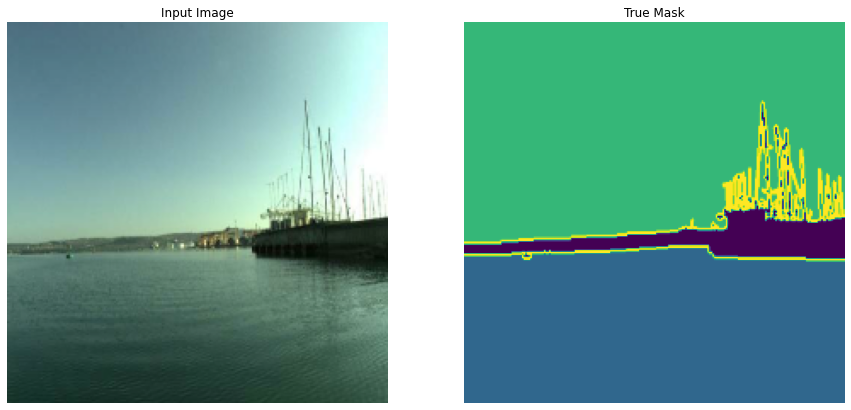

In [55]:
def show_predictions(dataset=None, num=1, show_sample=False, merge=False):
  '''
  For a given dataset plots one image, its true mask, and predicted mask

  Args
  ----------
  dataset (optional): tf.dataset object, defaults first image in testing set
  num (optional): int
  sample (optional): bool: if True, display prediction for sample image

  Returns
  ----------
  Nothing, graph will be displayed

  '''
  batches = num//BATCH_SIZE + 1 # How many batches 
  remainder = num%BATCH_SIZE
  if show_sample:
    display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], merge=merge) 
    return
  if dataset:
    for image, mask in dataset.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)
  else:
    for image, mask in test_ds.take(batches):
      pred_mask = model.predict(image[remainder][tf.newaxis, ...])
    display([image[remainder], mask[remainder], create_mask(pred_mask)], merge=merge)

for images, masks in val_ds.take(1):
  sample_image, sample_mask = images[5], masks[5] 

display([sample_image, sample_mask]) # careful, the display function is built in a nd redefined above TODO

### Shoreline Eval functions

In [56]:
def MODD2_shoreline_eval_single_image(gt_mask, pred_mask):

  '''
  Calculates the RMSE of horizon detection for a single image

  Args:
  ---------
  gt_mask: numpy.array (128, 128, 1)
  pred_mask: numpy.array (128, 128, 1)

  Returns:
  --------
  rmse: int
    (normalized) root mean square error of a single image
  '''

  HEIGHT = len(gt_mask)
  WIDTH = len(gt_mask[0, :])
  gt_len = 1

  diffs = np.empty(WIDTH) # new empty numpy array of width
  for i in range(WIDTH): # For width
    # print(gt_mask[:, i])
    # print(pred_mask[:, i])
    for j, val in enumerate(gt_mask[:, i]): # creates numbered list containing iteration index and corresponding value
      if val == 1:
        gt_len += 1
        break
    for k, val in enumerate(pred_mask[:, i]):
      if val == 1:
        break
    # if no detection along column, assume detection is at bottom of the image
    diffs[i] = abs(j - k)/HEIGHT
    # overflow occurs because of np division, shouldn't affect performance
    rmse = np.sqrt((sum(diffs)**2))/gt_len
  return rmse

# tic = time.perf_counter()
# gt_mask = sample_mask.numpy()
# pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...])).numpy()
# toc = time.perf_counter()
# print(f"preparing: {toc - tic:0.4f} seconds")

# tic = time.perf_counter()
# MODD2_shoreline_eval_single_image(gt_mask, pred_mask)
# toc = time.perf_counter()
# print(f"RMSE: {toc - tic:0.4f} seconds")

In [57]:
def MODD2_shoreline_eval(ds='test'):
  '''
  Returns score for the MODD2 evaluation of shoreline

  From MODD2 github page:
    For each pixel column in the full-sized image, a distance between water edge, 
    as given by the ground truth and as determined by the algorithm, is calculated. 
    These values are summarised into a single value by averaging across all 
    columns, frames and sequences.

  Args: 
  ----------
  ds: tf.dataset
    dataset object (either train_ds, val_ds, or test_ds)

  Returns:
  ----------
  (mean, std): tuple
    the mean and std for difference between prediction and gt
  '''
  if ds == 'test':
    ds_length = TEST_SIZE
    ds = test_ds
  elif ds == 'train':
    ds_length = TRAINSET_SIZE
    ds = train_ds
  elif ds == 'val':
    ds_length = VALSET_SIZE
    ds = val_ds
  elif ds == 'eval':
    ds_length = EVAL_SIZE
    ds = eval_ds
  else:
    print('Please input valid dataset name (either train, val, or test)')
    raise ValueError()

  num_batches = ds_length // BATCH_SIZE + 1

  # Loop through batches
  RMSEs = []
  for images, labels in tqdm(ds.take(num_batches)):
    preds = model.predict(images)
    # Loop through images within a batch:
    for i, label in enumerate(labels):
      # Have to convert to numpy, iterating through tensor is very slow
      gt_label = label.numpy()
      pred_label = create_mask(preds[i][tf.newaxis, ...]).numpy()

      RMSE = MODD2_shoreline_eval_single_image(gt_label, pred_label)
      RMSEs.append(RMSE)
  return RMSEs

### Training

**Custom loss function**

In the MasTr dataset, the edges of regions are labelled with class 4. The researchers took these regions as 'ambiguous' regions and ignore it. 

The loss function therefore need to ignore the pixels containing class 4

Problem: losing a lot of pixels 

In [58]:
UNLABELLED = 3.0

def custom_SparseCategoricalCrossentropy(y_true, y_pred):
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
  y_true = tf.boolean_mask(y_true, haslabel)
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True, axis=-1)


def custom_sigmoid_focal_crossentropy(y_true, y_pred):
  haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
  y_true = tf.boolean_mask(y_true, haslabel)
  y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
  y_pred = tf.boolean_mask(y_pred, haslabel)

  return tfa.losses.sigmoid_focal_crossentropy(y_true, y_pred, from_logits=True)

In [ ]:
def count_num_unlabelled():
  sum = 0
  for images, labels in val_ds.take(VALSET_SIZE//BATCH_SIZE+1):
    for image, y_true in zip(images, labels):
      y_true = y_true[tf.newaxis, ...]

      haslabel = tf.squeeze((y_true != UNLABELLED), axis=-1)
      y_true = tf.boolean_mask(y_true, haslabel)
      y_true = tf.squeeze(tf.one_hot(tf.cast(y_true, dtype='int32'), depth = 3, axis = 2))
      sum += 1-len(y_true)/(224*224)
  return sum/VALSET_SIZE

1 - count_num_unlabelled()

0.986736462089535

**Callbacks**

- `cp_callback`: saves the best checkpoint weight based on validation loss
- `tensorboard_callback`: writes results to tensorboard
- `rsme_callback`: computes rmse on eval and val set every 5 epochs, writes to tensorboard

In [ ]:
# TENSORBOARD CALLBACK
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = "training_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

try:
  os.mkdir(checkpoint_path)
except:
  pass

# CHECKPOINT CALLBACK
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'2',
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 monitor = 'val_accuracy',
                                                 verbose=1)

# RMSE CALLBACK
rmse_writer = tf.summary.create_file_writer(log_dir)

class RMSE_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
      if epoch%5 == 0:
        mean = np.mean(MODD2_shoreline_eval())
        mean_val = np.mean(MODD2_shoreline_eval('val'))
        with rmse_writer.as_default():
          tf.summary.scalar('RMSE_eval', mean, step=epoch)
          tf.summary.scalar('RMSE_val', mean_val, step=epoch)
        print('Test RMSE: {}'.format(mean))
        print('Val  RMSE: {}'.format(mean_val))

rmse_callback = RMSE_callback()

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Instantiate model or load model**

In [ ]:
# Retrieve model from drive to cwd 
retrieve_index = 'dropout-1000'
filename = '224x224-' + retrieve_index + 'e.zip'
model_path = '/content/drive/MyDrive/project_online/saved_models/' + filename
!unzip '$model_path' -d 'trained_model'

model = tf.keras.models.load_model('/content/trained_model/224x224-dropout-1000e', custom_objects={'custom_sigmoid_focal_crossentropy': custom_sigmoid_focal_crossentropy})

model.save_weights(checkpoint_path+ retrieve_index + 'e')

unzip:  cannot find or open $model_path, $model_path.zip or $model_path.ZIP.


OSError: No file or directory found at /content/trained_model/224x224-dropout-1000e

In [ ]:
model = unet_model(output_channels=N_CLASSES)
model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=custom_SparseCategoricalCrossentropy, #custom_sigmoid_focal_crossentropy,
              metrics=['accuracy'])

1/1 [==============================] - 0s 41ms/step


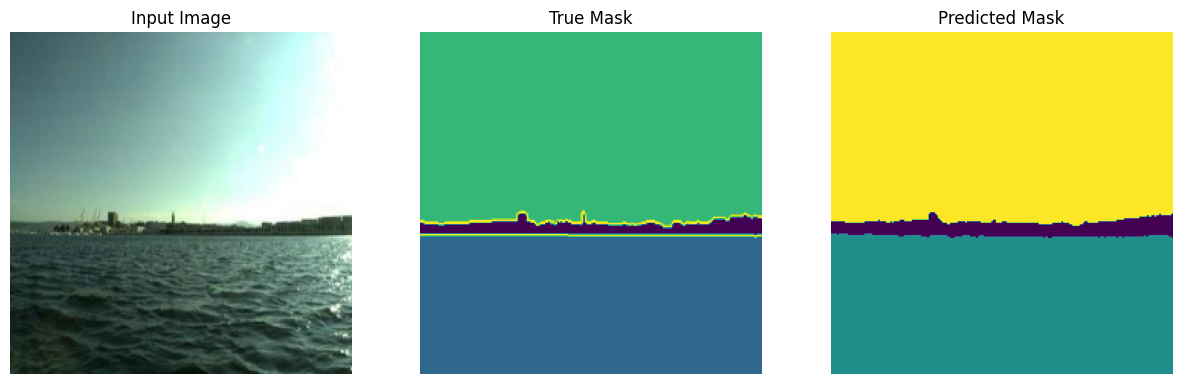

In [ ]:
# Check that everything is loaded properly
show_predictions(show_sample=True)

In [ ]:
EPOCHS = 200
STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

model_history_2 = model.fit(train_ds, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          callbacks=[cp_callback, tensorboard_callback],
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_ds)

Epoch 1/200
18/18 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.7596
Epoch 1: val_accuracy improved from -inf to 0.53151, saving model to training_checkpoints/cp.ckpt2
18/18 [==============================] - 68s 4s/step - loss: 0.5589 - accuracy: 0.7596 - val_loss: 1.3518 - val_accuracy: 0.5315
Epoch 2/200
18/18 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9094
Epoch 2: val_accuracy improved from 0.53151 to 0.83272, saving model to training_checkpoints/cp.ckpt2
18/18 [==============================] - 65s 4s/step - loss: 0.1774 - accuracy: 0.9094 - val_loss: 0.4680 - val_accuracy: 0.8327
Epoch 3/200
18/18 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9256
Epoch 3: val_accuracy improved from 0.83272 to 0.90025, saving model to training_checkpoints/cp.ckpt2
18/18 [==============================] - 65s 4s/step - loss: 0.1064 - accuracy: 0.9256 - val_loss: 0.2571 - val_accuracy: 0.9003
Epoch 4/200
18/18 [======

KeyboardInterrupt: 

In [ ]:
model.save_weights(checkpoint_path+'600')

### Experimental: unfreezing & training entire model

In [ ]:
# EPOCHS = 5
# STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
# VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

# down_stack.trainable=True

# model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-6),
#               loss=custom_sigmoid_focal_crossentropy,
#               metrics=['accuracy'])

# model_history = model.fit(train_ds, epochs=EPOCHS,
#                           steps_per_epoch=STEPS_PER_EPOCH,
#                           validation_steps=VALIDATION_STEPS,
#                           validation_data=val_ds)

In [ ]:
%tensorboard --logdir logs/fit


In [ ]:
# Load best model
# model.save_weights(checkpoint_path+'1300e')
# model.load_weights(checkpoint_path+'2')
model.load_weights(checkpoint_path+'600')

In [ ]:
# Calculate RMSEs
RMSEs_test, RMSEs_val, RMSEs_train, RMSEs_eval = 0, 0, 0, 0

RMSEs_test = MODD2_shoreline_eval()

mean = np.mean(RMSEs_test)
std = np.std(RMSEs_test)
print(mean, std)
# 0.01879525364004115 0.025340108952624577. (0.013802) #1239 

# 200e: 1452
# 400e: 1346 
# 600e: 1483

  0%|          | 0/41 [00:00<?, ?it/s]

2022-11-16 19:21:58.993997: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011177Lm.png; No such file or directory
2022-11-16 19:21:58.994024: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011181Lm.png; No such file or directory
2022-11-16 19:21:58.994045: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011179Lm.png; No such file or directory
2022-11-16 19:21:58.994067: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kaspe

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011177Lm.png; No such file or directory
	 [[{{node ReadFile_1}}]] [Op:IteratorGetNext]

In [ ]:
# Calculate RMSEs
RMSEs_eval = MODD2_shoreline_eval('eval')

mean = np.mean(RMSEs_eval)
std = np.std(RMSEs_eval)
print(mean, std)
# 0.025352097800063183 0.031343618588398944

  0%|          | 0/367 [00:00<?, ?it/s]

2022-11-16 19:22:10.649718: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004500Rm.png; No such file or directory
2022-11-16 19:22:10.649803: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004503Lm.png; No such file or directory
2022-11-16 19:22:10.651552: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004503Rm.png; No such file or directory
2022-11-16 19:22:10.653166: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kaspe

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004500Lm.png; No such file or directory
	 [[{{node ReadFile_1}}]] [Op:IteratorGetNext]

2022-11-16 19:22:10.813894: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004573Lm.png; No such file or directory
2022-11-16 19:22:10.813979: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004576Lm.png; No such file or directory
2022-11-16 19:22:10.814123: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope67-00-00004500-00005050/frames/00004576Rm.png; No such file or directory
2022-11-16 19:22:10.814191: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kaspe

In [ ]:
RMSEs_val = MODD2_shoreline_eval('val')

mean = np.mean(RMSEs_val)
std = np.std(RMSEs_val)
print(mean, std)

# 0.01081862798777507 0.011286257064264645

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.004983049361480958 0.0023602077551249435


In [ ]:
RMSEs_train = MODD2_shoreline_eval('train')

mean = np.mean(RMSEs_train)
std = np.std(RMSEs_train)
print(mean, std)
# 0.010701362492558989 0.07869251732263077

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in double_scalars



0.012441150529511325 0.013295066262898069


### Score Summary


In [ ]:
list_summary = []

list_summary.append([TRAINSET_SIZE, np.mean(RMSEs_train), np.std(RMSEs_train), np.mean(RMSEs_train) * 958])
list_summary.append([VALSET_SIZE, np.mean(RMSEs_val), np.std(RMSEs_val), np.mean(RMSEs_val) * 958])
list_summary.append([TEST_SIZE, np.mean(RMSEs_test), np.std(RMSEs_test), np.mean(RMSEs_test) * 958])
list_summary.append([EVAL_SIZE, np.mean(RMSEs_eval), np.std(RMSEs_eval), np.mean(RMSEs_eval) * 958])


df_summary = pd.DataFrame(data=list_summary, columns=['no.imgs', 'mean', 'std', 'mean-px'], index=['train', 'val', 'test', 'eval'])

df_summary

,no.imgs,mean,std,mean-px
train,1192,0.0,0.0,0.0
val,133,0.0,0.0,0.0
test,2590,0.0,0.0,0.0
eval,23479,0.0,0.0,0.0


In [ ]:
# Test images
# 27_128 (reflection)         take(3)
# 27_256 (building)           take(5)
# 27_384 (big wall right)     take(7)
# 27_448 (big wall mid)       take(8)
# 27_512 (big wall left)      take(9)
# --------------------------- (total 671 images)
# 28_33 (standard)            take(12)
# 28_417 (wall mid)           take(18)
# 28_609 (hazy)               take(21)

In [ ]:
index = 10

# test_ds.skip(6)
for image, mask in test_ds.take(7):
  display_image, display_mask = image[index], mask[index]

pred_mask = model.predict(display_image[tf.newaxis, ...])
pred_mask = create_mask(pred_mask)
display([display_image, display_mask, pred_mask])


2022-11-16 19:23:01.679478: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011178Rm.png; No such file or directory
2022-11-16 19:23:01.679528: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011179Rm.png; No such file or directory
2022-11-16 19:23:01.683126: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011178Lm.png; No such file or directory
2022-11-16 19:23:01.683157: W tensorflow/core/framework/op_kernel.cc:1780] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: /home/kaspe

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} /home/kasper/PycharmProjects/ShorelineNet/MODD2_video_data/video_data/kope82-00-00011177-00011797/frames/00011177Lm.png; No such file or directory
	 [[{{node ReadFile_1}}]] [Op:IteratorGetNext]

### Export detection results
```
Make folders 
For each image, decide which folder it is
  Detect
  Resize
  Save - filename_pred.png

zip and save to google drive
```




**Export Model Checkpoint**

In [ ]:
result_dir = '/content/results'
sequence_dirs = []

# Make folders
try:
  os.mkdir(os.path.join(os.getcwd(), 'results'))
  for i in range(28):
    sequence_dir = os.path.join(result_dir, f'seq{i+1:02d}')
    output_dir = os.path.join(sequence_dir, 'Unet')
    sequence_dirs.append(sequence_dir)
    os.mkdir(sequence_dir)
    os.mkdir(output_dir)
except:
  print('error raised')

error raised


In [ ]:
eval_dir = '/content/eval_data'
eval_image_dir = os.path.join(eval_dir, 'images')

for i in range(28):
  seq_foldername = f'seq{i+1:02d}'
  seq_filepath = os.path.join(eval_image_dir, seq_foldername)
  print(f'detecting results for {seq_foldername}...')
  for image in tqdm(sorted(os.listdir(seq_filepath))):
    if image.endswith('.jpg'):
      filename = image[:-4]
      filepath = os.path.join(seq_filepath, image)
      out_filename = filename + '_pred'
      out_filepath = os.path.join(result_dir, seq_foldername, out_filename + '.png')

      image = pimage.open(filepath)
      image = image.resize((224, 224))
      image_np = np.asarray(image)/255
      image_tensor = tf.convert_to_tensor(image_np)

      pred_mask = model.predict(image_tensor[tf.newaxis, ...])
      pred_mask = tf.squeeze(create_mask(pred_mask))
      
      pred_mask_np = pred_mask.numpy()
      pred_mask_np = np.repeat(np.expand_dims(pred_mask_np, axis=2), 3, axis=2)
      pred_mask_image = pimage.fromarray(pred_mask_np.astype(np.uint8), 'RGB')
      pred_mask_image = pred_mask_image.resize((512, 384))
      # print(out_filepath)
      pred_mask_image.save(out_filepath)

detecting results for seq01...



detecting results for seq02...



detecting results for seq03...



detecting results for seq04...



detecting results for seq05...



detecting results for seq06...



detecting results for seq07...



detecting results for seq08...



detecting results for seq09...



detecting results for seq10...



detecting results for seq11...



detecting results for seq12...



detecting results for seq13...



detecting results for seq14...



detecting results for seq15...



detecting results for seq16...



detecting results for seq17...



detecting results for seq18...



detecting results for seq19...



detecting results for seq20...



detecting results for seq21...



detecting results for seq22...



detecting results for seq23...



detecting results for seq24...



detecting results for seq25...



detecting results for seq26...



detecting results for seq27...



detecting results for seq28...


In [ ]:
# Zip and save to drive 
%%bash
cd results
zip -r 'Results_SNet_baseline_600e.zip' . -x '.*' -x '__MACOSX'

  adding: seq08/ (stored 0%)
  adding: seq08/00067761L_pred.png (deflated 50%)
  adding: seq08/00067762L_pred.png (deflated 49%)
  adding: seq08/00067604L_pred.png (deflated 51%)
  adding: seq08/00067804L_pred.png (deflated 55%)
  adding: seq08/00067702L_pred.png (deflated 47%)
  adding: seq08/00067287L_pred.png (deflated 56%)
  adding: seq08/00067400L_pred.png (deflated 52%)
  adding: seq08/00067302L_pred.png (deflated 54%)
  adding: seq08/00067447L_pred.png (deflated 55%)
  adding: seq08/00067558L_pred.png (deflated 48%)
  adding: seq08/00067737L_pred.png (deflated 47%)
  adding: seq08/00067576L_pred.png (deflated 52%)
  adding: seq08/00067510L_pred.png (deflated 49%)
  adding: seq08/00067352L_pred.png (deflated 55%)
  adding: seq08/00067342L_pred.png (deflated 51%)
  adding: seq08/00067477L_pred.png (deflated 57%)
  adding: seq08/00067766L_pred.png (deflated 49%)
  adding: seq08/00067457L_pred.png (deflated 52%)
  adding: seq08/00067828L_pred.png (deflated 50%)
  adding: seq08/00067

In [ ]:
!cp 'results/Results_SNet_baseline_600e.zip' '/content/drive/My Drive/project_online/'

## Export model

In [ ]:
out_filepath = 'SNet_baseline_600e'
out_zipfile = out_filepath + '.zip'

In [ ]:
model.save(filepath=out_filepath)

INFO:tensorflow:Assets written to: SNet_baseline_600e/assets


In [ ]:
out_filepath = 'SNet_baseline_600e'
out_zipfile = out_filepath + '.zip'
!zip -r '$out_zipfile' '$out_filepath' -x '.*' -x '__MACOSX'

  adding: SNet_baseline_600e/ (stored 0%)
  adding: SNet_baseline_600e/variables/ (stored 0%)
  adding: SNet_baseline_600e/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: SNet_baseline_600e/variables/variables.index (deflated 76%)
  adding: SNet_baseline_600e/saved_model.pb (deflated 92%)
  adding: SNet_baseline_600e/assets/ (stored 0%)
